# Joint probability experiment

In [199]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

R header:

In [200]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [201]:
# remove.packages("ptdalgorithms")

In [202]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [203]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [204]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [205]:
Rcpp::sourceCpp("./cpp/coalescent.cpp")

In [206]:
source("plot_functions.R")

In [207]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [208]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [209]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

## Section from Tobias paper that was taken out

We note that, although computationally infeasible in most situations, the joint distribution function of multivariate discrete phase-type distributions can also be described by such a recursive algorithm (and time-inhomogeneous multivariate discrete phase-type distributions as seen later). Instead of defining the probability of the system visiting a vertex at time $t$, we instead keep track of both the visited vertex and the accumulated reward at time $t$. Consider an $\ell+1$-dimensional table for an $\ell$-dimensional multivariate discrete phase-type distribution. The first dimension has $|V|$ entries, one for each vertex. The other dimensions has entries corresponding to the natural numbers from $0$ to $k$ where $k$ is sufficiently large, such that for a given distribution function of specified accumulated rewards $\vec{s}$, $F_{\vec{s}}$, then $k$ is larger or equal to any entry in $\vec{s}$. At a time $t$ an entry in the table corresponds to the probability of the system being in a specific state, and having accumulated a specific vector of integer rewards corresponding to the other dimensions. If we have accumulated more than any of the rewards $\vec{s}$, we assign probability zero to the entry in the table before the next time step. Assuming we have removed the vertices with zero rewards in all dimensions (e.g. using the reward transformation algorithm), then all time steps will increase at least one entry in the reward accumulation, and after a finite number of steps all entries will either be zero, or for the absorbing vertices the total probability of the system having reached an absorbing state with less than or equal to the rewards $\vec{s}$, which is the definition of the cumulative distribution function for the multivariate discrete phase-type distribution.

## Generate standard coalescent state space

If you want to generate the state space:

In [210]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

In [310]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# # self-transition rate:
# mutation_rate <- 1e-8

# # clone graph to get one to modify:
# mutation_graph <- clone_graph(graph)

# # add auxilliary states, normalize and return reward matrix:
# rewards <- make_discrete(mutation_graph, mutation_rate)

# # for plotting the new graph
# gam <- graph_as_matrix(mutation_graph)

## State space for joint proability computation

Generate coalescent state space like normal with the following modifications

- Change state space from (4, 0, 0, 0) to (4, 0, 0, 0, t1, t2, t3, t4). The last extra "ton" states keep track of the number accumulated mutations of each kind. We simply double the state vector so we keep track of the counts lineages with descendants, but also the counts of mutations happened on such lineages.
- Each state can mutate to accumulate a "ton" in accordance with its state vector. E.g., a `(4, 0, 0, 0, 0, 0, 0, 0)` state can only make singletons,  a `(2, 1, 0, 0, 0, 0, 0, 0)` state can only make singletons and doubletons.
- A mutation event is a transition to a siter state E.g., `(4, 0, 0, 0, 0, 0, 0, 0) -> (4, 0, 0, 0, 1, 0, 0, 0)`
- The ton counts have a maximum value (base-1). If this value is reached, the mutation transition instead leads to a trash state with an infinite self loop. The transitions to trash represents the part of the deficient PDF not covered because we only run up to a max nr of tons.

## Reward transform

- Convert the last half of each state (with ton counts) to numbers in some base.
- Use these for reward transformation.
- Compute PDF for t <- 1:sample_size^(base-1)
- Convert each time t back to the corresponding ton vector and associate it with the probability
- group by two tons and sum probs in groups to get all pairwise combinations for a joint probability matrix.

# Figure out why you get NAs in multi_rewards with max_tons <- 1

# NB: is it a discrete or continuous one i have built? I only evaluate at unit values... but PtD does think it is discrete (I use the conrinuous CDF function)

In [518]:
joint_prob_coalescent <- function(n, mutation_rate, max_tons, total_tons=Inf) {
    
    state_vector_length <- n + n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      # skip if we only have one lineage left or if this is a trash state
      if (sum(vertex$state[1:n]) <= 1) {
        index <- index + 1
        next
      }
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate
            )
        }
      }

      # mutations
      trash_rate <- 0 
      for (i in 1:n)  {
        rate <- vertex$state[i] * mutation_rate
        nr_tons <- child_state[n+i]
        if (rate > 0) {
            if (nr_tons < max_tons && sum(vertex$state[(n+1):(2*n)]) < total_tons) {
              child_state <- state
              child_state[n+i] <- child_state[i+n] + 1
              add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
            } else {
              trash_rate <- trash_rate + rate
            }
        }
      }
      if (trash_rate > 0) {
        add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
      }

      index <- index + 1
    }
    trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
    trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
    add_edge(trash_vertex, trash_loop_vertex, 1)
    add_edge(trash_loop_vertex, trash_vertex, 1)
    
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

# sample_size <- 4
# # mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
# mutation_rate <- 1
# max_tons <- 3
# base <- max_tons + 1
# # graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons)
# # gam <- graph_as_matrix(graph)
# # #gam

# graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons)
# gam <- graph_as_matrix(graph)
# plot_graph(gam, #subgraphs=TRUE, 
#            rainbow=TRUE,
#            size=c(10, 8), 
#            align=TRUE,
#            fontsize=16, ranksep=1, nodesep=0.25,          
#            # subgraphfun=function(state) paste(state[-length(state)], collapse="")
#            )

## Utility functions

In [519]:
ndigits <- function(x){
  y <- floor(abs(x))
  if(y != 0){
    floor(log10(y)) + 1
  } else {
    1
  }
}
rev_number=function(n){
    m=as.integer(rev(strsplit(as.character(n),"")))
    if (m==rev(m)) print("reversed number")
}
forth <- function(vec, base) {
    # return( as.integer( c(vec %*%  (base ^ rev(seq_along(vec)) / base)) ) )
    # return( as.integer( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) )
    # return( c(vec %*%  (base ^ (rev(seq_along(vec))) / base)) ) 
    return( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) 
}
back <- function(x, base, state_length) {
    # x <- as.integer(rev(paste(x, collapse='')))
    # x <- floor(as.numeric(rev(paste(x, collapse=''))))
    vec <- c()

    for (i in 1:state_length) {
        # if (x > 0) {
            vec <- c(x %% (base), vec)
            x <- x %/% (base)
        # }
    }

    # while (x > 0) {
    #     vec <- c(x %% (base), vec)
    #     x <- x %/% (base)
    # }
    
    # for (i in 1:ndigits(x)) {
    #     if (x > 0) {
    #         vec <- c(x %% (base), vec)
    #         x <- x %/% (base)
    #     }
    # }
    vec <- as.integer(vec)
    return( rev(c(rep(0, state_length-length(vec)), vec) ))
    # return( c(rep(0, state_length-length(vec)), vec) )
}
# vec <- c(1, 2, 0)
# base <- max(vec)+1
# state_length <- length(vec)
# print(vec)
# f <- forth(vec, base)
# print(f)
# b <- back(f, base, state_length)
# print(b)
# b <- c(rep(0, length(vec)-length(b)), b)
# print(b)

In [520]:
sample_size <- 4
# mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
mutation_rate <- 1
max_tons <- 1
base <- max_tons + 1
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons)
gam <- graph_as_matrix(graph)
#gam

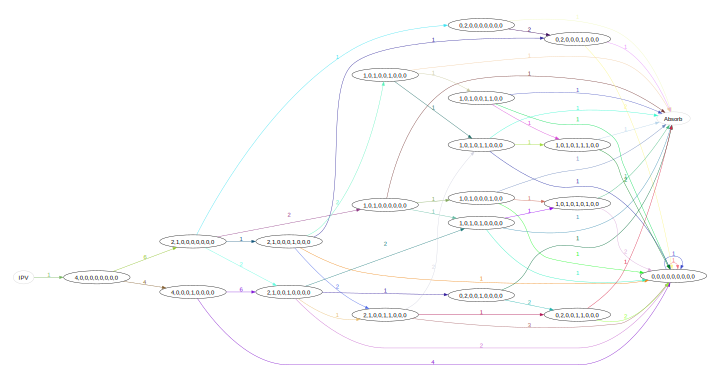

In [521]:
plot_graph(gam, #subgraphs=TRUE, 
           rainbow=TRUE,
           size=c(10, 8), 
           align=TRUE,
           fontsize=16, ranksep=1, nodesep=0.25,          
           # subgraphfun=function(state) paste(state[-length(state)], collapse="")
           )

Get last halves of states that server as mutation rewards:

In [522]:
rewards <- states(graph)[, (sample_size+1):(2*sample_size)]

Turn reward vectors into scalars (with the appropriate base):

In [523]:
multi_rewards <- apply(rewards, 1, forth, base=base)
# multi_rewards[22] <- 1
# #multi_rewards[length(multi_rewards)] <- 1
multi_rewards

[1] 0 0 0 1 0 0 1 2 0 0 2 1 4 1 3 2 2 1 5 4 3 3 6 5 3 7 6 7 0

Loop over states except starting to find trash vertices and give them a reward so they won't dissapear in the reward transformation. They will not contribute this reward because they are dead ends:

In [524]:
trash_states <- c()
for (i in 2:vertices_length(graph)) {
  vertex <- vertex_at(graph, i)
  if (sum(vertex$state) == 0) {
    multi_rewards[i] <- 1
    trash_states <- c(trash_states, i)

  }
}
trash_states

[1]  9 29

In [525]:
multi_rewards

[1] 0 0 0 1 0 0 1 2 1 0 2 1 4 1 3 2 2 1 5 4 3 3 6 5 3 7 6 7 1

Reward transform graph using scalar rewards:

In [526]:
rew_graph <- reward_transform(graph, multi_rewards)

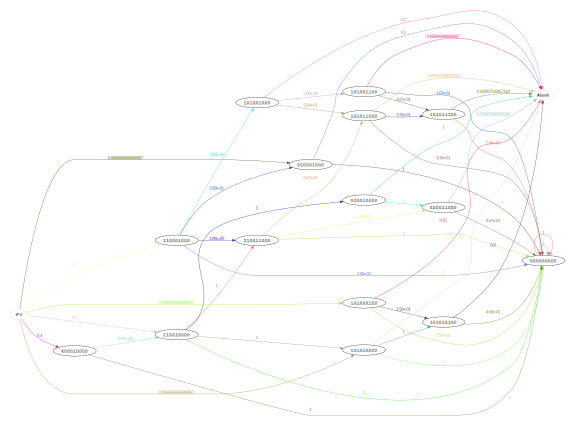

In [527]:
plot_graph(graph_as_matrix(rew_graph), #subgraphs=TRUE, 
           rainbow=TRUE,
           size=c(8, 8), 
           align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           # subgraphfun=function(state) paste(state[-length(state)], collapse="")
           )

Compute CDF and PDF assming no mutation count exceeds `max_tons`:

In [528]:
df <- data.frame(t=seq(0, base^(sample_size-1), 1))
# df <- data.frame(t=seq(0, length(multi_rewards), 1))
df['cdf'] <- sapply(df$t, function (t) pph(t, rew_graph))
tail(df)

,t,cdf
,<dbl>,<dbl>
4,3,0.3143025
5,4,0.3240618
6,5,0.3291231
7,6,0.3318765
8,7,0.3334283
9,8,0.3343261


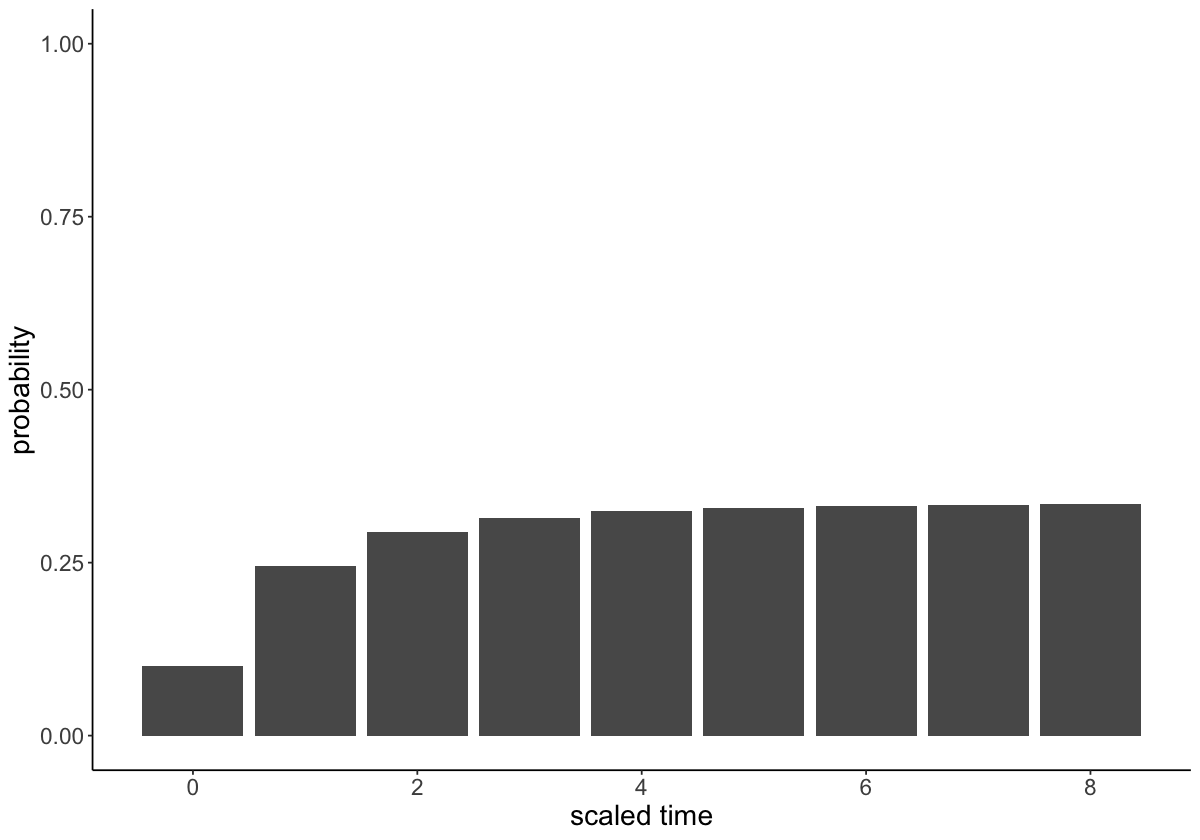

In [529]:
df %>% ggplot(aes(x=t, y=cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Compute probability of standing in on of the trash states for each time t in our CDF. These represent the deficit of the computed CDF:

In [530]:
trash_prob <- c()
for (i in 1:nrow(df)) {
    s <- stop_probability(graph, i)
    # trash_prob <- c(trash_prob, s[22] + s[39])
    trash_prob <- c(trash_prob, sum(s[trash_states]))
}
df['cdf_deficit'] <- trash_prob
tail(df)

,t,cdf,cdf_deficit
,<dbl>,<dbl>,<dbl>
4,3,0.3143025,0.6642270
5,4,0.3240618,0.6643144
6,5,0.3291231,0.6643206
7,6,0.3318765,0.6643210
8,7,0.3334283,0.6643210
9,8,0.3343261,0.6643210


CDF deficit:

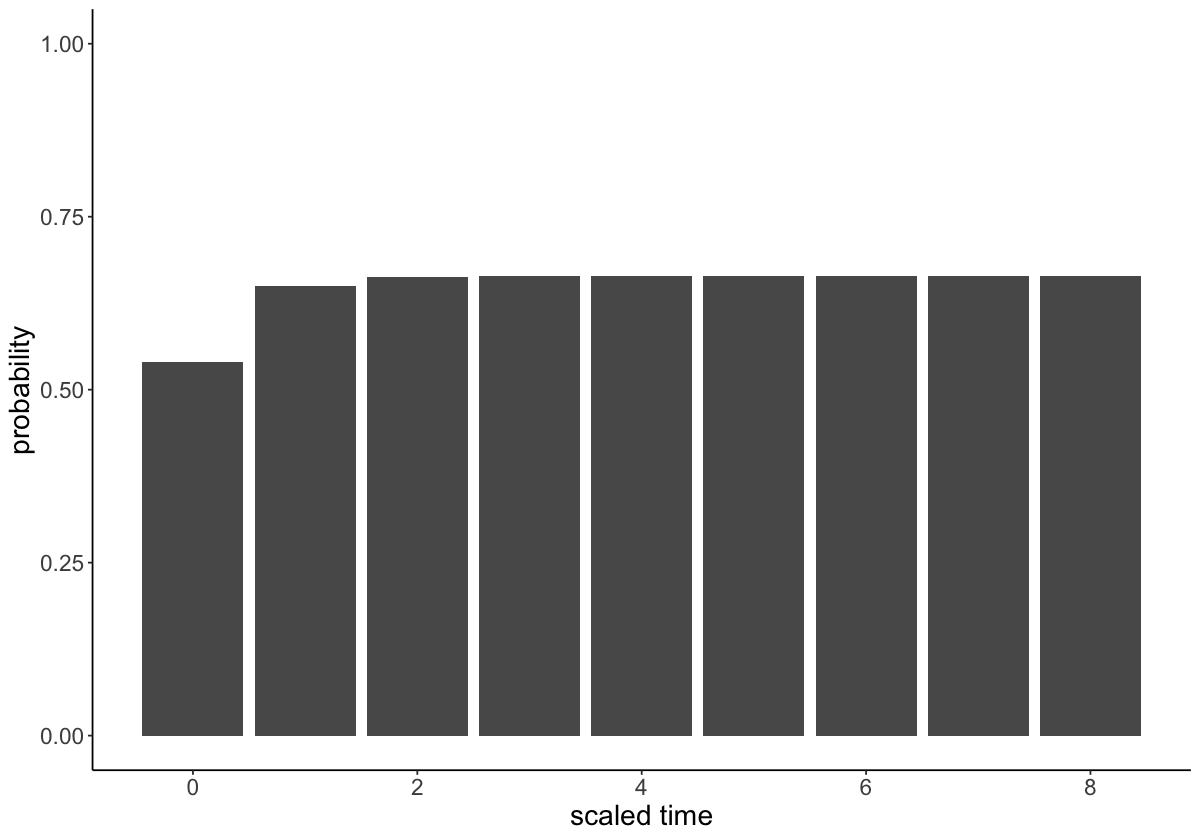

In [531]:
df %>% ggplot(aes(x=t, y=cdf_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Sanity check: adding CDF and deficit should produce a CDF that goes to 1:

In [532]:
df['cdf_full'] <- df$cdf + df$cdf_deficit

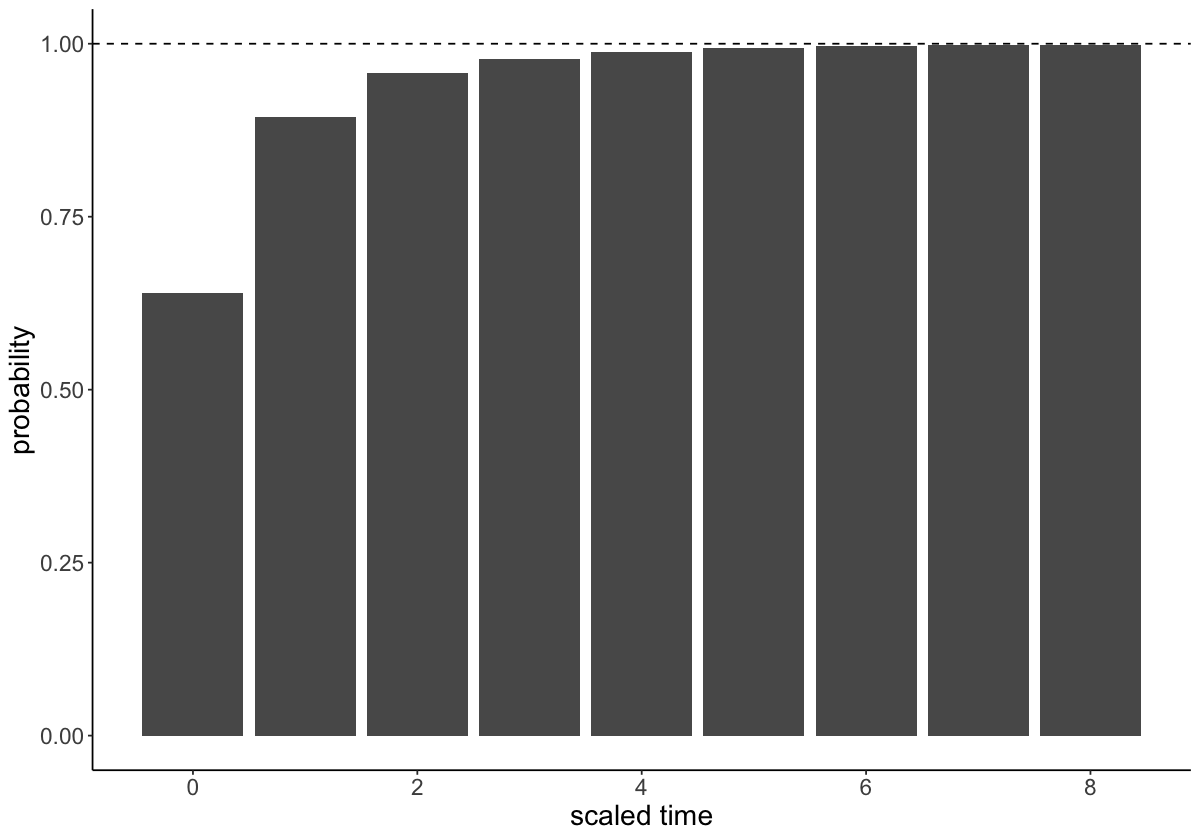

In [533]:
df %>% ggplot(aes(x=t, y=cdf_full)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + 
    ylim(0, 1) + 
    geom_hline(yintercept=1, linetype="dashed")

And the PDF from the full CDF should sum to one:

In [534]:
p <- df$cdf_full
df['pdf_from_cdf_full'] <- c(p[1], p[2:length(p)] - p[-length(p)])
#cdf <- cumsum(pdf)

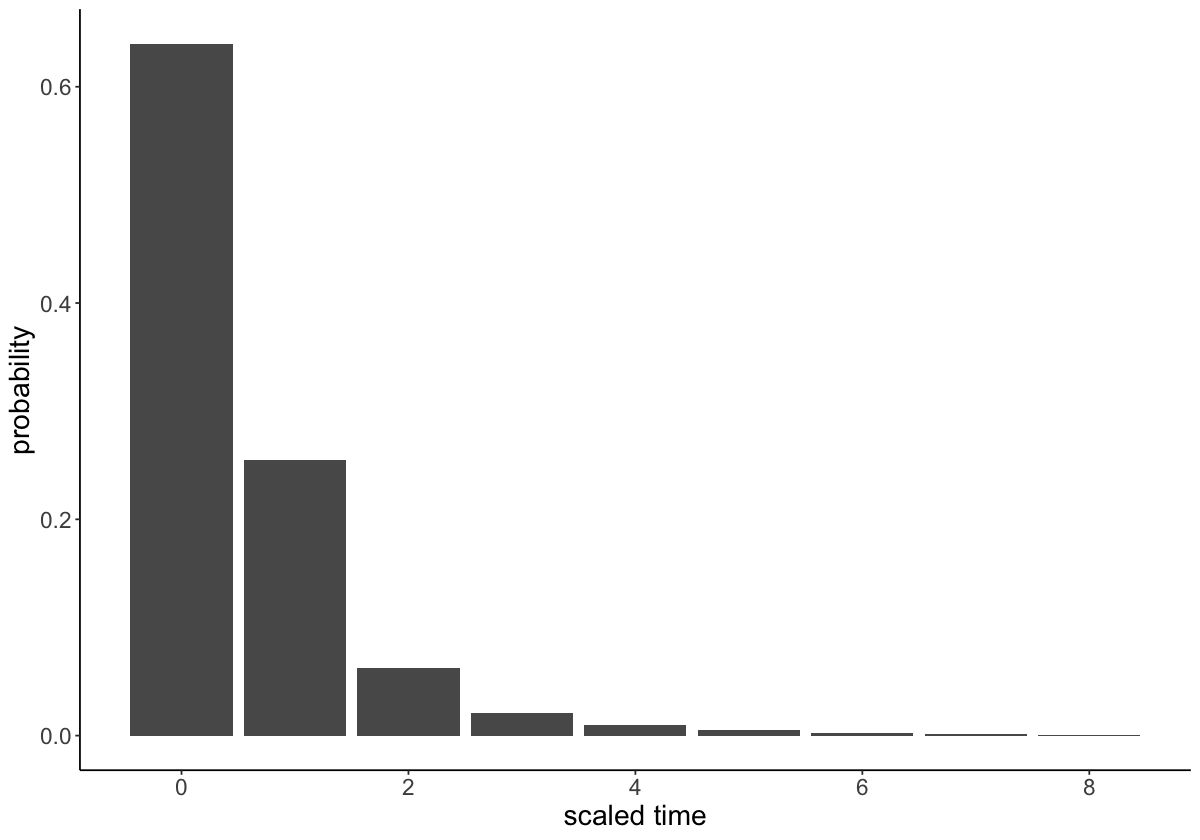

In [535]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf_full)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

In [536]:
sum(df$pdf_from_cdf_full)

[1] 0.9986471

It **ALMOST** does...

Compute PDF from the CDF (**this is the one we are after**):

In [537]:
p <- df$cdf
df['pdf_from_cdf'] <- c(p[1], p[2:length(p)] - p[-length(p)])

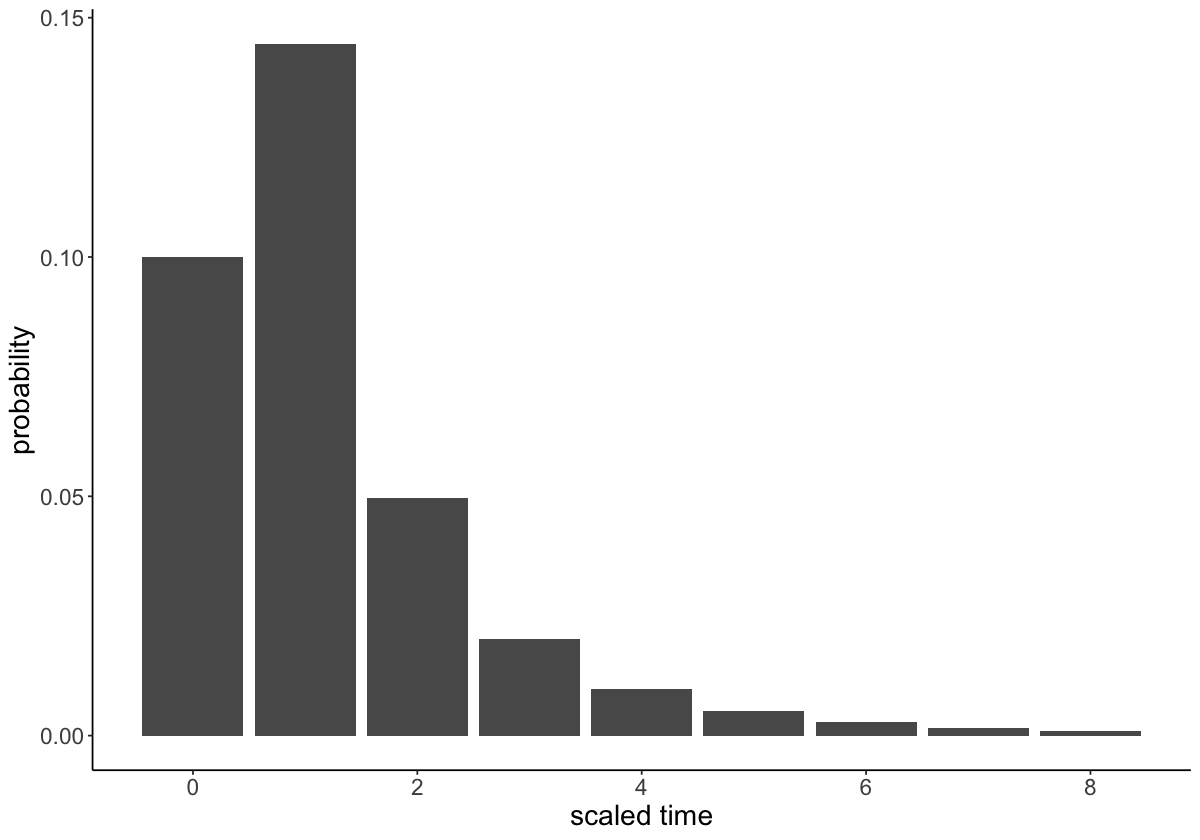

In [538]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

The reason we need to go through the CDF to get the PDF is that the PDF function in PtD computes the distribution of times when the absorbing state is reached. It this cannot take the deficit in trash_states into account. The PDF commputed directly looks like this:

In [539]:
df['pdf'] <- sapply(df$t, function (t) dph(t, rew_graph))

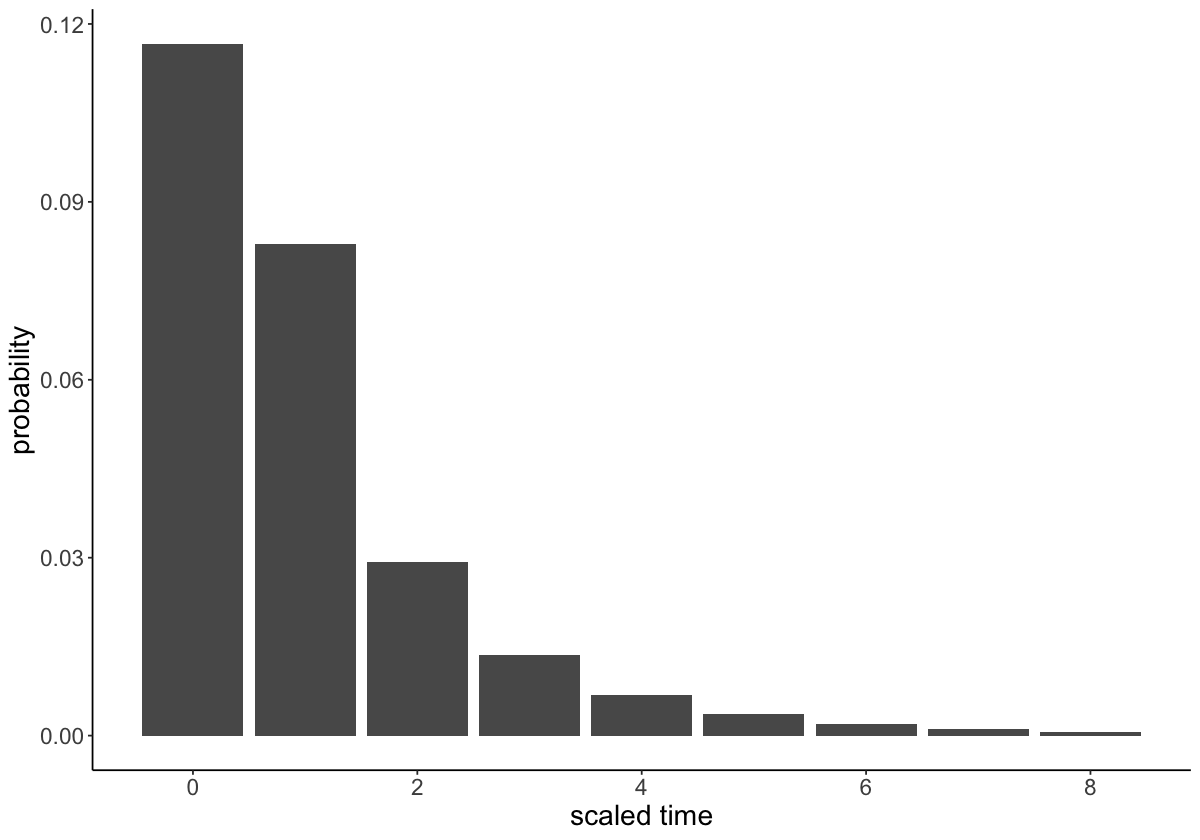

In [540]:
df %>% ggplot(aes(x=t, y=pdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine 

In [542]:
sum(df$pdf)

[1] 0.2566932

Convert reward scalars back into state vectors representing ton counts:

In [543]:
df['prob'] = df$pdf_from_cdf
x <- lapply(df$t, back, base=base, state_length=sample_size)
m <- do.call(rbind, x)
multi_df <- data.frame(m)
multi_df['prob'] = df$prob
head(multi_df)

,X1,X2,X3,X4,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0.100000000
2,1,0,0,0,0.144563255
3,0,1,0,0,0.049551799
4,1,1,0,0,0.020187405
5,0,0,1,0,0.009759319
6,1,0,1,0,0.005061287


In [544]:
tail(multi_df)

,X1,X2,X3,X4,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,1,0,0,0.0201874045
5,0,0,1,0,0.0097593188
6,1,0,1,0,0.0050612868
7,0,1,1,0,0.0027534379
8,1,1,1,0,0.0015518365
9,0,0,0,1,0.0008977983


In [556]:
sum(multi_df$prob)

[1] 0.3343261

In [545]:
#multi_df[which(rowSums(multi_df[1:3]) == 2),]

,X1,X2,X3,X4,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,1,0,0,0.020187405
6,1,0,1,0,0.005061287
7,0,1,1,0,0.002753438


In [547]:
plot_df <- multi_df %>% group_by(X2, X3) %>% summarise(joint_prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X2'. You can override using the `.groups` argument.


X2,X3,joint_prob
<fct>,<fct>,<dbl>
0,0,0.245461053
0,1,0.014820606
1,0,0.069739203
1,1,0.004305274


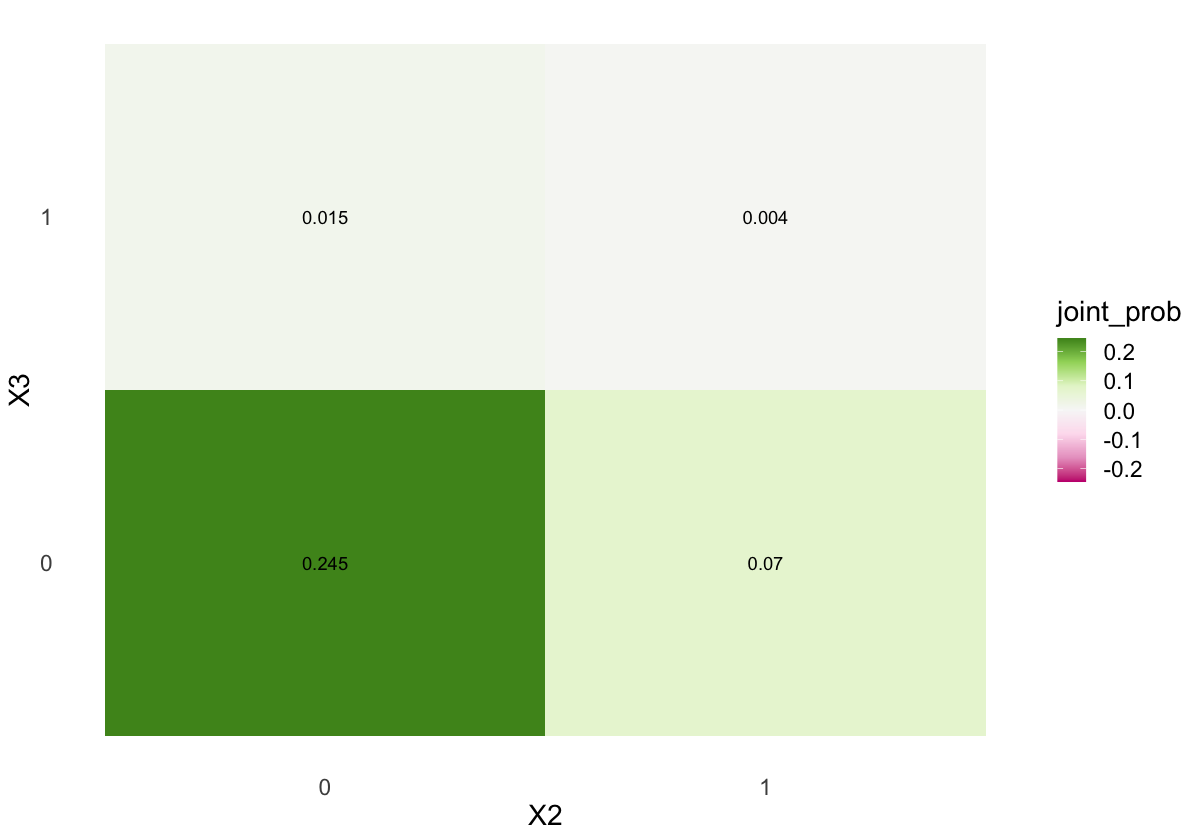

In [548]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = joint_prob)) + 
    geom_text(aes(label = round(joint_prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$joint_prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

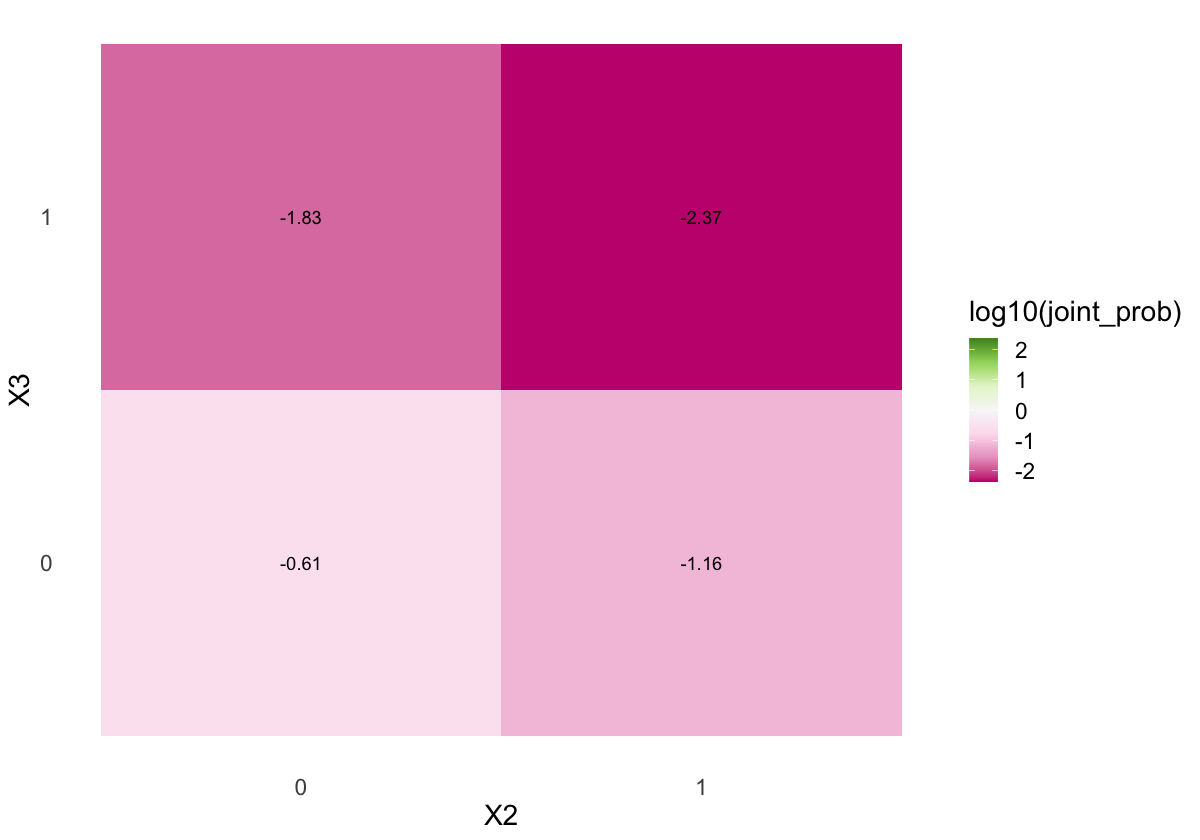

In [549]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = log10(joint_prob))) + 
    geom_text(aes(label = round(log10(joint_prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$joint_prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


# Constraining the total number of mutations

Just like we can limit the number of each king of tons in the state space contruction, we can also limit the total number of mutations so that we, for example, can have at most one instance of two different tons (`total_tons=2`). E.g., a singleton and a tripleton.

In [ ]:
sample_sizes <- 3:10

In [577]:
sample_sizes <- 3:10
times <- c()

#sample_size <- 5
for (sample_size in sample_sizes) {
mutation_rate <- 1
max_tons <- 1
base <- max_tons + 1

start <- proc.time()[3]            
    
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons=Inf)

rewards <- states(graph)[, (sample_size+1):(2*sample_size)]
multi_rewards <- apply(rewards, 1, forth, base=base)
trash_states <- c()
for (i in 2:vertices_length(graph)) {
  vertex <- vertex_at(graph, i)
  if (sum(vertex$state) == 0) {
    multi_rewards[i] <- 1
  }
}
rew_graph <- reward_transform(graph, multi_rewards)

df <- data.frame(t=seq(0, base^(sample_size-1), 1))
df['cdf'] <- sapply(df$t, function (t) pph(t, rew_graph))
p <- df$cdf
df['pdf_from_cdf'] <- c(p[1], p[2:length(p)] - p[-length(p)])

x <- lapply(df$t, back, base=base, state_length=sample_size)
m <- do.call(rbind, x)
joint_df <- data.frame(m)
joint_df['prob'] = df$pdf_from_cdf

times <- c(times, proc.time()[3] - start)                    
}
tail(joint_df)             

sample_size,times
<int>,<dbl>
3,0.002
4,0.003
5,0.011
6,0.048
7,0.206
8,1.039
9,4.171
10,17.974


In [ ]:
data.frame(sample_size=sample_sizes, times=times)                    

In [560]:
sum(joint_df$prob)

[1] 0.3343261

In [552]:
plot_df <- joint_df %>% group_by(X2, X3) %>% summarise(joint_prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X2'. You can override using the `.groups` argument.


X2,X3,joint_prob
<fct>,<fct>,<dbl>
0,0,0.764006173
0,1,0.036388208
1,0,0.188335554
1,1,0.009198971


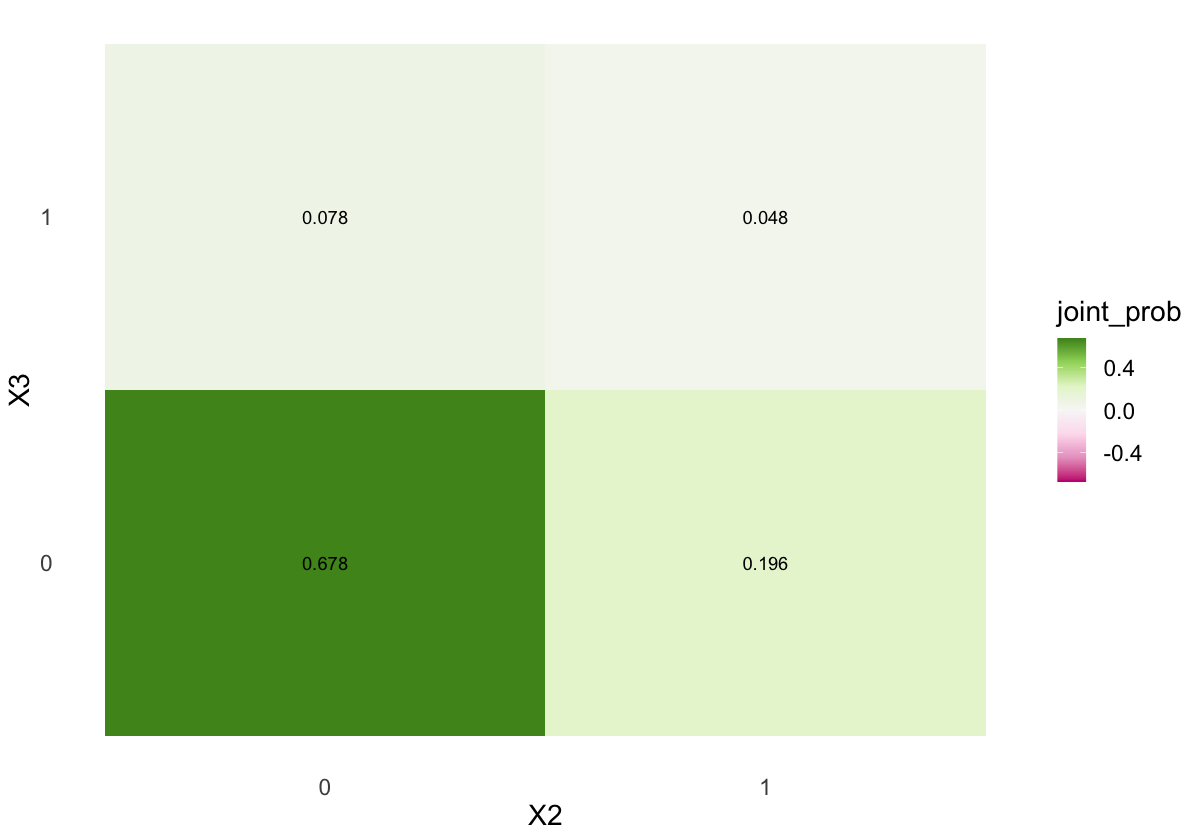

In [511]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = joint_prob)) + 
    geom_text(aes(label = round(joint_prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$joint_prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

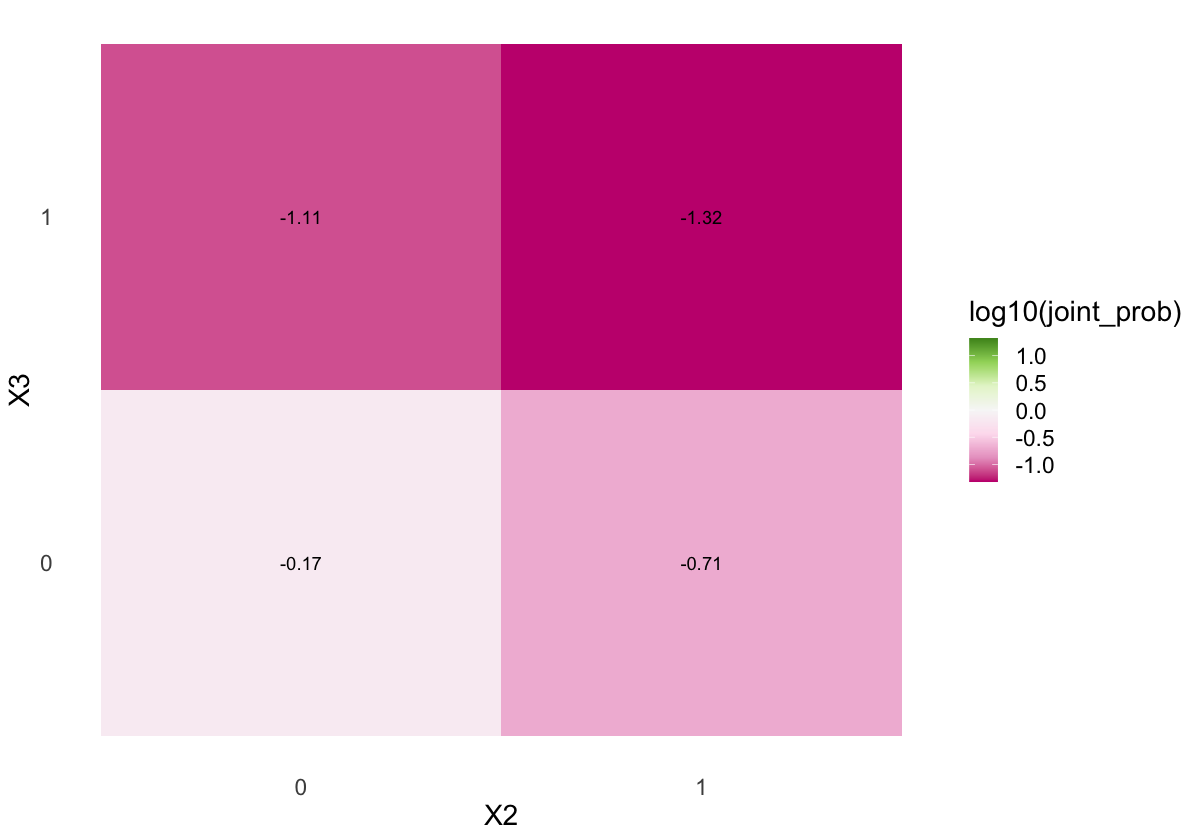

In [512]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = log10(joint_prob))) + 
    geom_text(aes(label = round(log10(joint_prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$joint_prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))
